In [ ]:
%load_ext autoreload
%autoreload 2

In [93]:
import time
from pprint import pprint
from IPython.display import display
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import h5py
from sklearn.model_selection import train_test_split 

import torch
torch.set_default_dtype(torch.float64)

import e3nn
import e3nn.point.data_helpers as dh 
from training_utils import *

In [3]:
# make sure CUDA is available
print(torch.cuda.current_device())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
print(torch.cuda.is_available())
print(torch.version.cuda)
device = "cuda"
#torch.rand(10).to(device)
#torch.rand(10, device=device)

0
1
Quadro M4000
True
10.1


In [123]:
# read stationary data
with h5py.File("acetone/acetone-b3lyp_d3bj-631gd-gas-equilibrium_geometry.hdf5", "r") as h5:
    atomic_numbers = np.array(h5.get("atomic_numbers"))
    isotropic_shieldings = np.array(h5.get("isotropic_shieldings"))
print(atomic_numbers)
atomic_symbols_dict = {1:"H", 6:"C", 8:"O"}
atomic_symbols = [ atomic_symbols_dict[i] for i in atomic_numbers ]
print(atomic_symbols)
print(isotropic_shieldings)
n_atoms = len(isotropic_shieldings)

[6 8 6 1 1 1 6 1 1 1]
['C', 'O', 'C', 'H', 'H', 'H', 'C', 'H', 'H', 'H']
[ -20.1123 -337.7406  159.0655   29.4662   29.4664   29.7726  159.0733
   29.4659   29.4658   29.773 ]


In [132]:
# read perturbed data
with h5py.File("acetone/acetone-b3lyp_d3bj-631gd-gas-NMR-pcSseg_1.hdf5", "r") as h5:
    geoms_and_shieldings = np.array(h5.get("data"))
print(np.shape(geoms_and_shieldings))
geometries = geoms_and_shieldings[:,:,:3]
shieldings = geoms_and_shieldings[:,:,3]

(100000, 10, 4)


In [133]:
element_width_dict = { 1 : 1.2, 6 : 6.0, 8 : 54.0 }
widths = [ element_width_dict[i] for i in atomic_numbers ]
widths = np.array(widths)
shieldings = (shieldings - isotropic_shieldings)/widths
print(np.mean(shieldings,axis=0))
print(np.std(shieldings,axis=0))

[19.50568406  0.70020909  7.11058595  0.63287213  0.62730283  0.2619862
  7.10518024  0.62701463  0.62589273  0.25319787]
[1.02828526 1.00093492 1.03926091 1.01509924 1.01725567 1.00940395
 1.03488899 1.01124638 1.01476318 1.00599361]


In [125]:
# normalize data on a per-site basis
# this is extreme, but let's see how well we can do with this
#means = np.mean(shieldings, axis=0)
#stdevs = np.std(shieldings, axis=0)
#shieldings = (shieldings-means)/stdevs

In [134]:
# generate one-hot features
print(atomic_numbers)
one_hots = pd.get_dummies(atomic_numbers)
print(one_hots)
one_hots = one_hots.to_numpy()

# get some shapes
n_examples = geometries.shape[0]
n_atoms_per_example = geometries.shape[1]
n_one_hots = one_hots.shape[1]

# features are just one-hots, so repeat the same one-hots for every training example
desired_shape = (n_examples, n_atoms_per_example, n_one_hots)
features = np.zeros(desired_shape)
features[:] = one_hots              # broadcast one_hots into every row along axis 0

[6 8 6 1 1 1 6 1 1 1]
   1  6  8
0  0  1  0
1  0  0  1
2  0  1  0
3  1  0  0
4  1  0  0
5  1  0  0
6  0  1  0
7  1  0  0
8  1  0  0
9  1  0  0


In [135]:
# features are one-hots for every atom,
# so this is (number of one_hots, rank zero tensor, even parity)
Rs_in = [(n_one_hots,0,1)]

# we are outputing one scalar for every atom
# so this is (one, rank zero tensor, even parity)
Rs_out = [(1,0,1)]

# maximum extent of radial basis functions in Angstroms
max_radius = 2.0

In [136]:
class DataNeighborsSelection(dh.DataNeighbors):
    def __init__(self, x, Rs_in, pos, r_max, atomic_numbers, relevant_atomic_numbers=None, self_interaction=True, **kwargs):
        if atomic_numbers is None:
            raise ValueError("atomic_numbers must be defined")
        if relevant_atomic_numbers is None:
            relevant_atomic_numbers = [1, 6]  
        relevant_atom_index = [i for i, atom_number in enumerate(atomic_numbers)
                               if atom_number in relevant_atomic_numbers]
        relevant_atom_index = torch.LongTensor(relevant_atom_index).unsqueeze(0)  # [1, N]
        
        super().__init__(x, Rs_in, pos, r_max,
                         self_interaction=self_interaction,
                         atomic_numbers=atomic_numbers, 
                         relevant_atom_index=relevant_atom_index,
                         **kwargs)

In [161]:
# save a subset of the data to a .torch file
# precompute the relevant neighbors
relevant_atomic_numbers = [1, 6]

def save_dataset(geometry_subset, shielding_subset, feature_subset, output_filename):
    dataset = []
    n_to_save = len(geometry_subset)
    print(f"Preprocessing for {output_filename}:")
    for i,(g,s,f) in enumerate(zip(geometry_subset, shielding_subset, feature_subset)):
        g,s,f = torch.tensor(g, dtype=torch.float64), torch.tensor(s, dtype=torch.float64).unsqueeze(-1), torch.tensor(f, dtype=torch.float64)
        data = DataNeighborsSelection(x=f, Rs_in=Rs_in, pos=g, r_max=max_radius,
                                      atomic_numbers=atomic_numbers, relevant_atomic_numbers=relevant_atomic_numbers,
                                      y=s, Rs_out=Rs_out)
        dataset.append(data)
        if (i+1) % 100 == 0 or i == n_to_save - 1:
            print(f"{i+1:10d} of {n_to_save:10d}...", end="\r", flush=True)
    print("\nWriting to disk...", end="", flush=True)
    torch.save(dataset, output_filename)
    print(f"done.  Saved {len(dataset)} records.")
    
# splits the dataset randomly into training and test sets
# train_size = # number of training examples
# test_size = # number of test examples
# prefix = filenames will start with this string
# random_state = for reproducible splits
def split_and_save(train_size, test_size, prefix, random_state):
    assert train_size + test_size <= n_examples
    #[ training_geometries, training_shieldings, training_features,
    #  testing_geometries, testing_shieldings, testing_features     ]
    splitting = train_test_split(geometries, shieldings, features,
                                test_size = test_size, train_size = train_size,
                                random_state = random_state, shuffle = True)
    save_dataset(*splitting[::2], f"{prefix}-train.torch")
    save_dataset(*splitting[1::2], f"{prefix}-test.torch")

In [162]:
train_size = 5000
test_size = 5000
split_and_save(train_size, test_size, "acetone-split1", 1)

Preprocessing for acetone-split1-train.torch:
      5000 of       5000...
Writing to disk...done.  Saved 5000 records.
Preprocessing for acetone-split1-test.torch:
      5000 of       5000...
Writing to disk...done.  Saved 5000 records.


In [163]:
dataset1 = torch.load("acetone-split1-train.torch")
dataset2 = torch.load("acetone-split1-test.torch")
batch_size = 50
train_dataloader = tg.data.DataListLoader(dataset1, batch_size=batch_size, shuffle=True)
test_dataloader = tg.data.DataListLoader(dataset2, batch_size=batch_size, shuffle=False)

In [164]:
# define the neural network architecture
model_kwargs = {
    'network': 'GatedConvParityNetwork', 
    'conv': 'Convolution',
    'Rs_in': Rs_in,            # shape of inputs
    'Rs_out': Rs_out,          # shape of outputs
    'mul': 5,                 # how many copies of each tensor at each layer
    'lmax': 2,                 # maximum angular momentum
    'layers': 3,               # number of layers
    'max_radius': max_radius,  # radial kernel will extend out this far
    'number_of_basis': 10,     # number of Gaussians in radial kernel
}
model = model_from_kwargs(model_kwargs)

In [165]:
# training parameters
learning_rate = 1e-2
opt = torch.optim.Adam(model.parameters(), learning_rate)
max_iter = 10       
n_norm = 5           # n_norm is average number of convolution neighbors per atom

In [166]:
def loss_function(output, data):
    index = data.relevant_atom_index
    predictions = output[index]
    observations = data.y[index]
    loss = (predictions-observations).square().mean()
    return loss

In [167]:
model.to(device)
n_batches = int(train_size / batch_size)
for i in range(max_iter):
    start_time = time.time()
    loss_cum = torch.tensor(0.)
    for j,data in enumerate(train_dataloader):
        print(f"Iteration {i+1:5d}    batch {j+1:5d} / {n_batches:5d}", end="\r", flush=True)
        data = tg.data.Batch.from_data_list(data)
        data.to(device)
        output = model(data.x, data.edge_index, data.edge_attr, n_norm=n_norm)
        loss = loss_function(output, data)
        loss_cum += loss
        opt.zero_grad()
        loss.backward()
        opt.step()
    end_time = time.time()
    elasped_time = end_time - start_time
    print(f"Iteration {i+1:5d}    batch {j+1:5d} / {n_batches:5d}  loss = {loss_cum.data / (j+1):7.4f}    elapsed = {elasped_time:7.2f} s")
    #break

Iteration     1    batch   100 /   100  loss =  2.4241    elapsed =   28.37 s
Iteration     2    batch   100 /   100  loss =  0.0459    elapsed =   28.88 s
Iteration     3    batch   100 /   100  loss =  0.0265    elapsed =   28.98 s
Iteration     4    batch   100 /   100  loss =  0.0193    elapsed =   28.94 s
Iteration     5    batch   100 /   100  loss =  0.0160    elapsed =   28.79 s
Iteration     6    batch   100 /   100  loss =  0.0134    elapsed =   28.41 s
Iteration     7    batch   100 /   100  loss =  0.0116    elapsed =   28.47 s
Iteration     8    batch   100 /   100  loss =  0.0112    elapsed =   29.05 s
Iteration     9    batch   100 /   100  loss =  0.0114    elapsed =   28.66 s
Iteration    10    batch   100 /   100  loss =  0.0110    elapsed =   28.64 s


In [168]:
# test the model as it now
torch.cuda.empty_cache()
model.to(device)
n_batches = int(test_size / batch_size)
start_time = time.time()

predictions = []
observations = []

loss_cum = torch.tensor(0.)
for j,data in enumerate(test_dataloader):
    print(f"batch {j+1:5d} / {n_batches:5d}", end="\r", flush=True)
    data = tg.data.Batch.from_data_list(data)
    data.to(device)
    with torch.no_grad():
        output = model(data.x, data.edge_index, data.edge_attr, n_norm=n_norm)
        predictions_this_batch = output.reshape((batch_size,n_atoms)).cpu().numpy()
        observations_this_batch = data.y.reshape((batch_size,n_atoms)).cpu().numpy()
        predictions.append(predictions_this_batch)
        observations.append(observations_this_batch)
        loss = loss_function(output, data)
    loss_cum += loss
loss_cum = loss_cum/(j+1)
end_time = time.time()
elasped_time = end_time - start_time
print(f"\nOverall loss is {loss_cum:.4f}.  Evaluation took {elasped_time:.2f} s.")
predictions = np.concatenate(predictions)
observations = np.concatenate(observations)

batch   100 /   100
Overall loss is 0.0138.  Evaluation took 7.73 s.


In [169]:
def undo_scaling(v):
    #return v * stdevs + means
    return v * widths + isotropic_shieldings
unscaled_predictions = undo_scaling(predictions)
unscaled_observations = undo_scaling(observations)
residuals = unscaled_predictions - unscaled_observations
print(np.shape(residuals))

(5000, 10)


In [170]:
relevant_atomic_numbers = [1, 6]  
relevant_atom_index = [i for i, atom_number in enumerate(atomic_numbers)
                               if atom_number in relevant_atomic_numbers]
print(relevant_atom_index)

[0, 2, 3, 4, 5, 6, 7, 8, 9]


In [171]:
pd.set_option('precision',4)
df = pd.DataFrame(residuals, columns = [ f"{j}{i+1}" for i,j in enumerate(atomic_symbols) ] )
df = df.iloc[:,relevant_atom_index].copy()
display(df.head())

,C1,C3,H4,H5,H6,C7,H8,H9,H10
0,-1.8041,-0.0875,-0.0561,-0.0711,0.0580,-0.8175,-0.1038,-0.0301,-0.0297
1,-1.7511,-0.4972,-0.0743,0.0101,-0.0463,-1.0421,-0.0068,0.0026,-0.0853
2,0.3539,-1.1460,-0.0539,-0.0617,0.0238,-1.6708,-0.0910,0.0013,-0.0339
3,-1.6414,0.1514,0.0906,0.0093,-0.0501,-0.3687,0.0179,0.0059,0.0553
4,-0.4053,0.4035,0.1735,0.0033,0.0250,-0.8052,-0.0487,0.0660,-0.0869


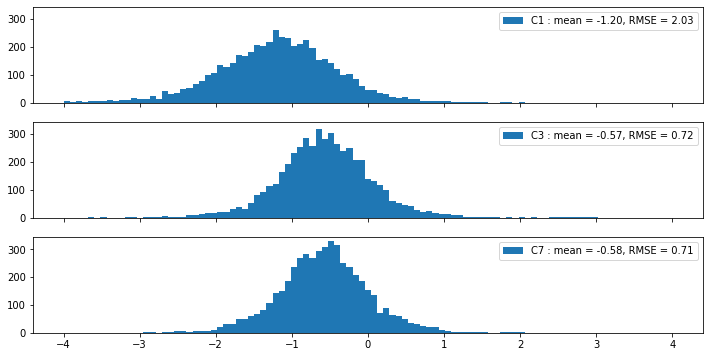

In [172]:
fig, axs = plt.subplots(3,1,sharex='col',sharey='col',figsize=(12,6))
bins = np.linspace(-4,4,100)
def plot(where, what):
    mean = what.mean()
    RMSE = what.pow(2).mean()
    axs[where].hist(what, bins=bins, label=f"{what.name} : mean = {mean:.2f}, RMSE = {RMSE:.2f}")
    axs[where].legend(loc='upper right')
plot(0,df.C1)
plot(1,df.C3)
plot(2,df.C7)
plt.show()

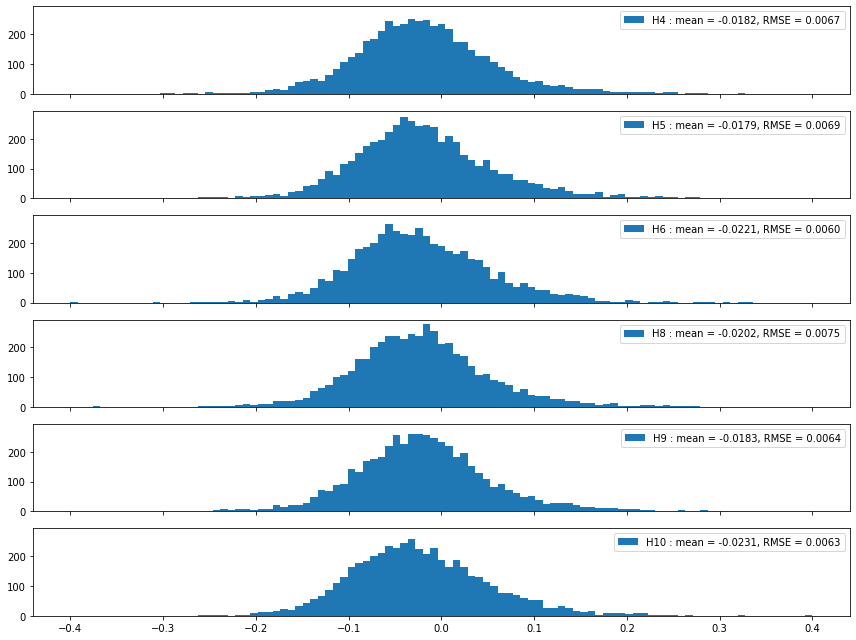

In [173]:
fig, axs = plt.subplots(6,1,sharex='col',sharey='col',figsize=(12,9))
bins = np.linspace(-0.4,0.4,100)
def plot(where, what):
    mean = what.mean()
    RMSE = what.pow(2).mean()
    axs[where].hist(what, bins=bins, label=f"{what.name} : mean = {mean:.4f}, RMSE = {RMSE:.4f}")
    axs[where].legend(loc='upper right')
plot(0,df.H4)
plot(1,df.H5)
plot(2,df.H6)
plot(3,df.H8)
plot(4,df.H9)
plot(5,df.H10)
plt.tight_layout()
plt.show()